<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Afib_PPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2. Setup Environment

In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle
print(tf.__version__)

2.1.0


In [0]:
#run this cell if multiple GPUs are used
tf.debugging.set_log_device_placement(True)

In [0]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [0]:
tf.test.is_built_with_cuda()

True

# 3. Clean data

### 3.1 Load data

In [0]:
hd_names = []
for name in glob.glob("D:/WFDB/matched/p00/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  27303 records that are bigger than 17kb


In [0]:
qualified_names = [] #a list of file names that contain both PPG and ECG Lead I waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'I' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #extact only records contrains ECG lead I and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ECG and PPG with more than 10min recording')

There are total 361 records that have both ECG and PPG with more than 10min recording


In [0]:
##use the same name for wfdb.rdrecord
##sampling freq is 125 Hz for both ECG and PPG: 
##Documentation: https://archive.physionet.org/physiobank/database/mimic3wdb/
ECG_signals = [] #create a  list to store all  ECG signals
PPG_signals = [] #create a  list to store all  PPG signals
for name in qualified_names:
  record = wfdb.rdrecord(name)

  ECG_index = record.sig_name.index('I')
  PPG_index = record.sig_name.index('PLETH')
  ECG_sig = record.p_signal.T[ECG_index]
  PPG_sig = record.p_signal.T[PPG_index]

  if np.isnan(ECG_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
    continue
  else:
    ECG_signals.append(ECG_sig)
    PPG_signals.append(PPG_sig)

print('ECG signals len:', len(ECG_signals))
print('PPG signals len:', len(PPG_signals))

ECG signals len: 214
PPG signals len: 214


In [0]:
#save the data
#save ECG data
with open('D:/WFDB/matched/ECG_signals.pkl', "wb") as fp:
  pickle.dump(ECG_signals, fp)
#save PPG data
#with open('D:/WFDB/matched/PPG_signals.pkl', "wb") as fp:
  #pickle.dump(PPG_signals, fp)

In [0]:
with open('D:/WFDB/matched/ECG_signals.pkl', "rb") as fp:
  ECG_signals = pickle.load(fp)

## Resample ECG signals 

In [0]:
#use wfdb.resample
from wfdb import processing
new_ECG_signals = []
for i in range(len(ECG_signals)):
  new_ECG_signal, _ = wfdb.processing.resample_sig(ECG_signals[i],125,300)
  new_ECG_signals.append(new_ECG_signal)
#apply filters before using DEEP-ECG to label it

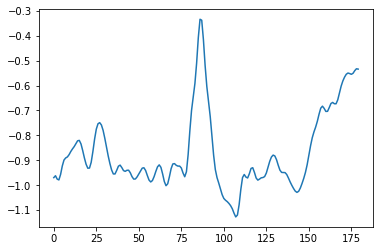

In [0]:
plt.plot(new_ECG_signals[1][:180]*-1)

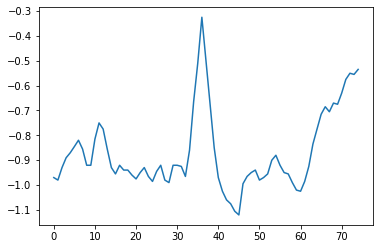

In [0]:
plt.plot(ECG_signals[1][:75]*-1)

In [0]:
with open('D:/WFDB/matched/ECG_signals_300HZ.pkl', "wb") as fp:
  pickle.dump(new_ECG_signals, fp)

In [0]:
with open('D:/WFDB/matched/ECG_signals_300HZ.pkl', "rb") as fp:
  new_ECG_signals = pickle.load(fp)

##Flip ECG signals

In [0]:
r_ECG_signals = np.multiply(new_ECG_signals, -1)

In [4]:
len(new_ECG_signals)

214

In [5]:
r_ECG_signals.shape

(214,)

## Band pass filter



In [0]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [0]:
f_ECG_signal =butter_bandpass_filter(r_ECG_signals[1],0.2,8,300,order=3)

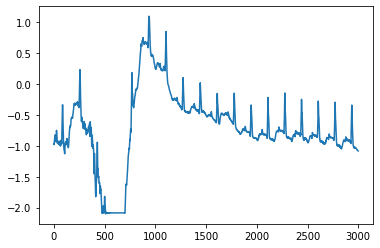

In [62]:
plt.plot(r_ECG_signals[1][:3000])

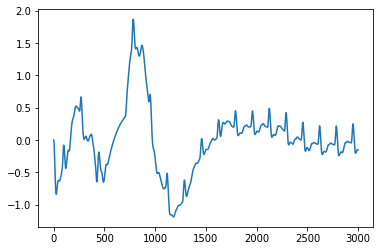

In [63]:
plt.plot(f_ECG_signal[:3000])

## Normalization

##Hampel filter

In [0]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [0]:
res, detected_outliers = hampel_filter_forloop(r_ECG_signals[1], 10)

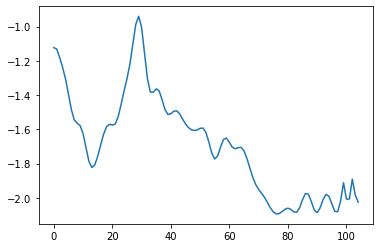

In [81]:
plt.plot(res[400:505])

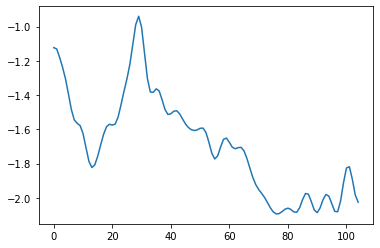

In [82]:
plt.plot(r_ECG_signals[1][400:505])

##Flat line and peak removal

In [0]:
##

## Data processing for PPG signals

In [0]:
##From BP paper: https://github.com/supertime1/bp-estimation-mimic3
#1. length check - remove files <1min already did when loading the data 
#2. ppg/ecg normalization - zero mean and unit variance??
#3. ppg/ecg band-pass filter - butterworth 4th order (0.5 to 8 Hz)
#4. cycle segmentation - elgendi algorithm for peak detection
#5. ppg outlier removal - hempel filter (6 samples, 3 stds)
#6. flat line and peak removal (consecutive samples with same value)

## Build model